<a href="https://colab.research.google.com/github/JustineDataEng/Air-Quality-PM2.5-Forecasting-A-Comparative-Case-Study/blob/main/Air_Quality_Data_LASSO_Poly_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell imports all the necessary Python libraries for data manipulation, visualization, and time series modeling. These include `glob` for file handling, `time` and `datetime` for date operations, `pprint` for pretty printing, `matplotlib.pyplot` and `plotly.express` for plotting, `pandas` and `numpy` for data handling, `seaborn` for statistical graphics, `sklearn.metrics` for evaluation, and `statsmodels` for time series analysis (ACF, PACF, SARIMAX).

In [ ]:
from glob import glob
import time
from datetime import datetime
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

This cell defines a `wrangle` function that encapsulates all the data cleaning and preprocessing steps for a single CSV file. It performs the following operations:
- Reads the CSV file using pandas.
- Filters for `value_type` equal to 'P2' (PM2.5).
- Drops irrelevant columns (`sensor_id`, `sensor_type`, `location`, `lat`, `lon`, `value_type`).
- Renames the `value` column to `P2`.
- Converts the `timestamp` column to datetime objects.
- Sets the `timestamp` as the DataFrame index and converts its timezone to 'Africa/Dar_es_Salaam'.
- Filters out `P2` values greater than 100.
- Resamples the data to an hourly frequency, calculates the mean, and forward-fills missing values.
- Creates a lagged feature `P2.L1` (previous hour's PM2.5 reading).
- Drops any remaining rows with `NaN` values.

This function ensures consistent preprocessing across all input CSV files.

In [ ]:
def wrangle(collection):
  df = pd.read_csv(collection, sep=';')

  return df

This cell uses the glob module to find all files ending with .csv in the current directory and stores their names in the files variable. This is done to easily access and process all the available sensor data files. The output shows a list of the CSV filenames found.

In [ ]:
files = glob('*.csv')
files


['january_2018_sensor_data_archive.csv',
 'march_2018_sensor_data_archive.csv',
 'november_2017_sensor_data_archive.csv',
 'february_2018_sensor_data_archive.csv',
 'december_2017_sensor_data_archive.csv',
 'october_2017_sensor_data_archive.csv']

This code applies the `wrangle` function (defined earlier) to each CSV file identified in `files`, creating a list of processed DataFrames. These DataFrames are then concatenated into a single DataFrame `df`. The output shows the first few rows of the concatenated DataFrame, indicating the processed PM2.5 (`P2`) values and their lagged versions (`P2.L1`) indexed by timestamp.

In [ ]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames)
# df = df.sort_index()
df.head()

,P2,P2.L1
timestamp,,
2018-01-01 04:00:00+03:00,9.130625,9.545361
2018-01-01 05:00:00+03:00,9.381979,9.130625
2018-01-01 06:00:00+03:00,9.644388,9.381979
2018-01-01 07:00:00+03:00,8.973021,9.644388
2018-01-01 08:00:00+03:00,8.560313,8.973021


This cell filters the DataFrame `df` to include only rows where the `value_type` column is 'P2'.

In [ ]:
df = df[df["value_type"] == "P2"]
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,29,SDS011,11,-6.818,39.285,2018-01-01T00:00:04.053149+00:00,P2,9.27
3,33,SDS011,11,-6.818,39.285,2018-01-01T00:00:46.551725+00:00,P2,7.70
7,31,SDS011,11,-6.818,39.285,2018-01-01T00:00:56.670711+00:00,P2,7.77
10,23,SDS011,11,-6.818,39.285,2018-01-01T00:02:02.795325+00:00,P2,13.17
12,29,SDS011,11,-6.818,39.285,2018-01-01T00:02:33.847744+00:00,P2,8.17


This code drops several columns (`sensor_id`, `sensor_type`, `location`, `lat`, `lon`) that are not directly relevant for time-series forecasting of PM2.5 levels.

In [ ]:
df.drop(columns=["sensor_id",	"sensor_type",	"location",	"lat",	"lon"], inplace=True)
df

,timestamp,value_type,value
0,2018-01-01T00:00:04.053149+00:00,P2,9.27
3,2018-01-01T00:00:46.551725+00:00,P2,7.70
7,2018-01-01T00:00:56.670711+00:00,P2,7.77
10,2018-01-01T00:02:02.795325+00:00,P2,13.17
12,2018-01-01T00:02:33.847744+00:00,P2,8.17
...,...,...,...
132494,2017-10-31T23:57:02.509564+00:00,P2,6.80
132497,2017-10-31T23:59:07.237953+00:00,P2,9.50
132501,2017-10-31T23:59:21.896782+00:00,P2,9.07
132504,2017-10-31T23:59:31.297393+00:00,P2,12.00


The `value` column is renamed to `P2` for clarity, indicating it represents PM2.5 readings. The `value_type` column is then dropped as it's no longer needed after filtering and renaming. This results in a cleaner DataFrame with only `timestamp` and `P2` columns.

In [ ]:
df = df.rename(columns={'value': 'P2'})
df.drop(columns=["value_type"], inplace=True)
df

,timestamp,P2
0,2018-01-01T00:00:04.053149+00:00,9.27
3,2018-01-01T00:00:46.551725+00:00,7.70
7,2018-01-01T00:00:56.670711+00:00,7.77
10,2018-01-01T00:02:02.795325+00:00,13.17
12,2018-01-01T00:02:33.847744+00:00,8.17
...,...,...
132494,2017-10-31T23:57:02.509564+00:00,6.80
132497,2017-10-31T23:59:07.237953+00:00,9.50
132501,2017-10-31T23:59:21.896782+00:00,9.07
132504,2017-10-31T23:59:31.297393+00:00,12.00


This cell sorts the DataFrame by its index, which is the `timestamp` column. Sorting ensures that the time series data is in chronological order, a crucial step for any time series analysis or forecasting task.

In [ ]:
df = df.sort_index()
df

,P2,P2.L1
timestamp,,
2017-10-08 14:00:00+03:00,13.831111,9.246000
2017-10-08 15:00:00+03:00,10.700000,13.831111
2017-10-08 16:00:00+03:00,10.700000,10.700000
2017-10-08 17:00:00+03:00,10.700000,10.700000
2017-10-08 18:00:00+03:00,10.700000,10.700000
...,...,...
2018-03-31 22:00:00+03:00,9.547083,9.547083
2018-03-31 23:00:00+03:00,6.301765,9.547083
2018-04-01 00:00:00+03:00,7.293125,6.301765


This code generates descriptive statistics for the `P2` and `P2.L1` columns. The output provides key metrics like count, mean, standard deviation, min, max, and quartiles. This helps in understanding the distribution and range of the PM2.5 readings. The `P2` and `P2.L1` columns show very similar statistics, which is expected given `P2.L1` is simply a shifted version of `P2`.

In [ ]:
df.describe()

,P2,P2.L1
count,4184.000000,4184.000000
mean,8.178986,8.177996
std,5.296924,5.296073
min,0.754028,0.754028
25%,4.253557,4.253557
50%,7.176389,7.176389
75%,10.700000,10.700000
max,57.019787,57.019787


A box plot is generated to visualize the distribution of PM2.5 readings. This plot helps identify the median, quartiles, and any potential outliers in the `P2` column.

<Axes: title={'center': 'Distribution of PM2.5 Readings'}>

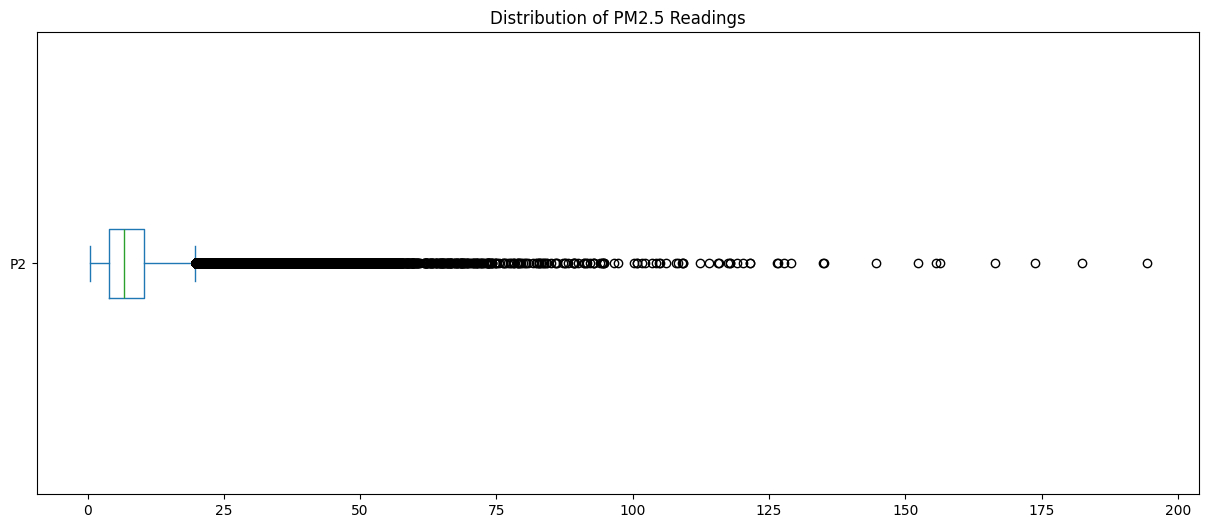

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

df["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax)

This code filters out any `P2` values greater than 100.

In [ ]:
df = df[df["P2"] <= 100]

In [ ]:
df.describe()

,P2
count,302595.000000
mean,7.845984
std,5.790795
min,0.400000
25%,3.900000
50%,6.630000
75%,10.270000
max,97.270000


Another box plot is generated after the potential filtering for values <= 100. Similar to the previous box plot, this visualization helps to confirm the distribution of the `P2` values after any filtering.

<Axes: title={'center': 'Distribution of PM2.5 Readings'}>

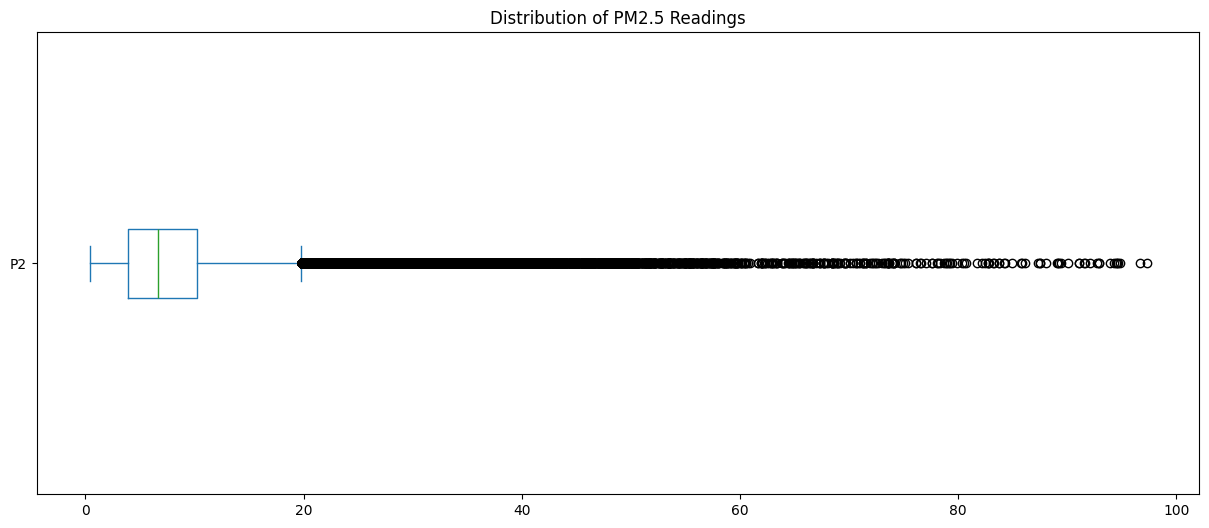

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

df["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax)

This crucial step resamples the `P2` data to an hourly frequency, calculates the mean for each hour, and fills any missing hourly data using the forward-fill method (`ffill`). This transforms the irregular time series into a regular hourly series, which is suitable for time series modeling. The output shows the first few rows of the hourly aggregated data.

In [ ]:
df = df["P2"].resample("1H").mean().fillna(method="ffill").to_frame()
df.head()

,P2
timestamp,
2017-10-08 13:00:00+03:00,9.246000
2017-10-08 14:00:00+03:00,13.831111
2017-10-08 15:00:00+03:00,10.700000
2017-10-08 16:00:00+03:00,10.700000
2017-10-08 17:00:00+03:00,10.700000


A new column `P2.L1` is created, which represents the PM2.5 reading from the previous hour (lag-1). This is a common feature engineering technique for time series data, as previous values often have a strong correlation with current values. The head of the DataFrame shows the `P2.L1` column with the shifted values, and the first entry is `NaN` as there's no preceding value to shift.

In [ ]:
df["P2.L1"] = df["P2"].shift(1)
df.head(10)

,P2,P2.L1
timestamp,,
2017-10-08 13:00:00+03:00,9.246000,NaN
2017-10-08 14:00:00+03:00,13.831111,9.246000
2017-10-08 15:00:00+03:00,10.700000,13.831111
2017-10-08 16:00:00+03:00,10.700000,10.700000
2017-10-08 17:00:00+03:00,10.700000,10.700000
2017-10-08 18:00:00+03:00,10.700000,10.700000
2017-10-08 19:00:00+03:00,10.700000,10.700000
2017-10-08 20:00:00+03:00,10.700000,10.700000
2017-10-08 21:00:00+03:00,10.700000,10.700000


This cell plots the time series of the `P2` readings. This visualization helps to understand the trends, seasonality, and any irregular patterns in the data over time.

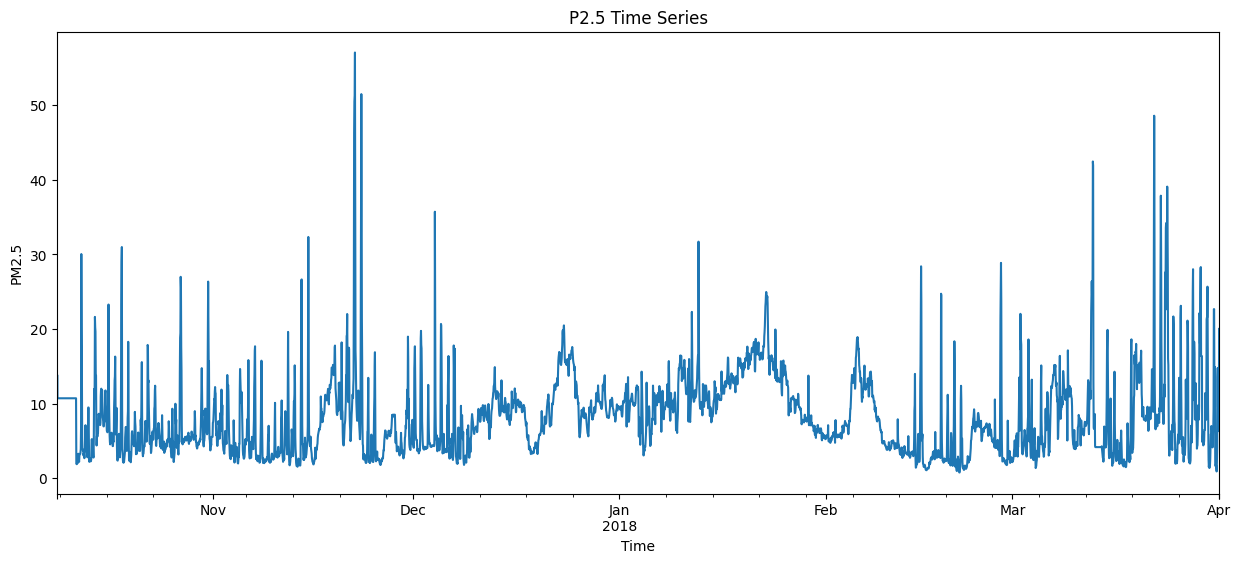

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(xlabel="Time", ylabel="PM2.5", title="P2.5 Time Series", ax=ax);

This code calculates the 168-hour (7-day) rolling mean of the `P2` column. A rolling mean helps to smooth out short-term fluctuations and highlight longer-term trends or seasonality. The output shows the rolling mean series, with `NaN` values at the beginning until enough data points are available for the window.

In [ ]:
df["P2"].rolling(168).mean()

,P2
timestamp,
2017-10-08 14:00:00+03:00,NaN
2017-10-08 15:00:00+03:00,NaN
2017-10-08 16:00:00+03:00,NaN
2017-10-08 17:00:00+03:00,NaN
2017-10-08 18:00:00+03:00,NaN
...,...
2018-03-31 22:00:00+03:00,8.840712
2018-03-31 23:00:00+03:00,8.852267
2018-04-01 00:00:00+03:00,8.873289


This step removes any rows with `NaN` values from the DataFrame. This is necessary because the `P2.L1` column introduced `NaN` for the first entry. Dropping these ensures that all rows used for modeling have complete data. The head of the DataFrame confirms that the row with `NaN` in `P2.L1` (the first row after creating the lagged feature) has been removed. **Note:** This step is redundant as the `wrangle` function already drops NaN values at the end.

In [ ]:
df.dropna(inplace=True)
df.head()

,P2,P2.L1
timestamp,,
2017-10-08 14:00:00+03:00,13.831111,9.246000
2017-10-08 15:00:00+03:00,10.700000,13.831111
2017-10-08 16:00:00+03:00,10.700000,10.700000
2017-10-08 17:00:00+03:00,10.700000,10.700000
2017-10-08 18:00:00+03:00,10.700000,10.700000


This cell plots the 168-hour (weekly) rolling mean of the `P2` values. This visualization further highlights the weekly trends and seasonality in the PM2.5 data, providing insights into recurring patterns.

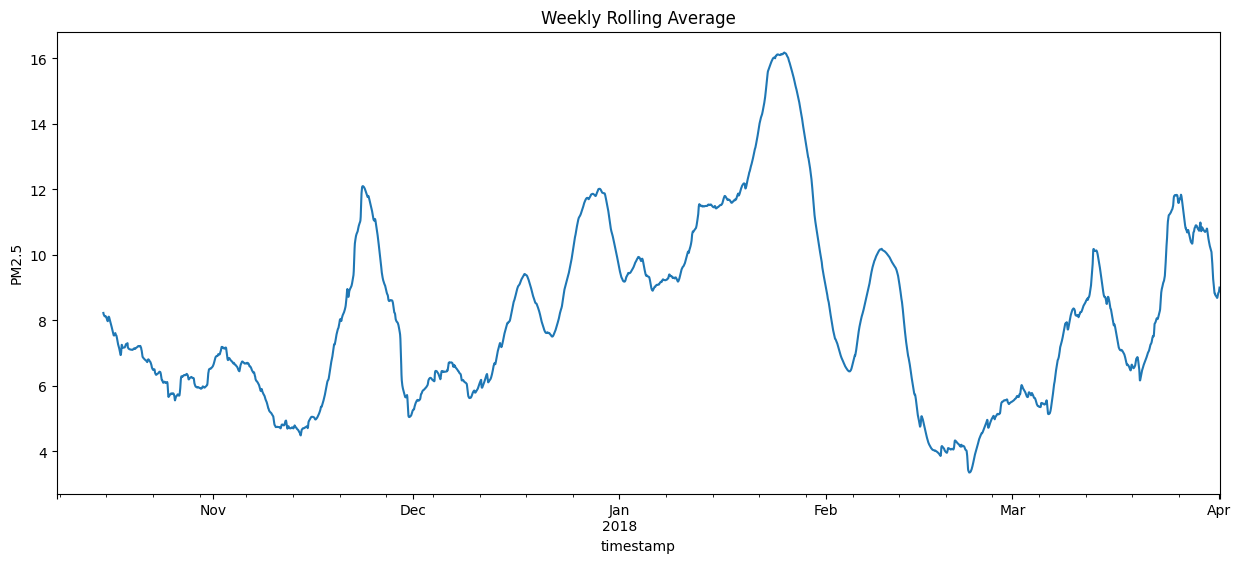

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

df["P2"].rolling(168).mean().plot(ax=ax, ylabel="PM2.5", title="Weekly Rolling Average");

This code calculates the correlation matrix for the DataFrame `df` and rounds the results to two decimal places. The output shows a strong positive correlation (0.9) between `P2` and `P2.L1`, indicating that the PM2.5 value at the current hour is highly correlated with the value from the previous hour. This suggests that the lagged feature `P2.L1` will be very useful for prediction.

In [ ]:
df.corr().round(2)

,P2,P2.L1
P2,1.0,0.9
P2.L1,0.9,1.0


This cell generates a scatter plot to visualize the autocorrelation between `P2` (current PM2.5 value) and `P2.L1` (previous hour's PM2.5 value). A dashed orange line representing `y=x` is added for reference. The plot confirms the strong positive linear relationship observed in the correlation matrix, indicating high autocorrelation in the time series.

Text(0.5, 1.0, 'PM2.5 AutoCorrelation')

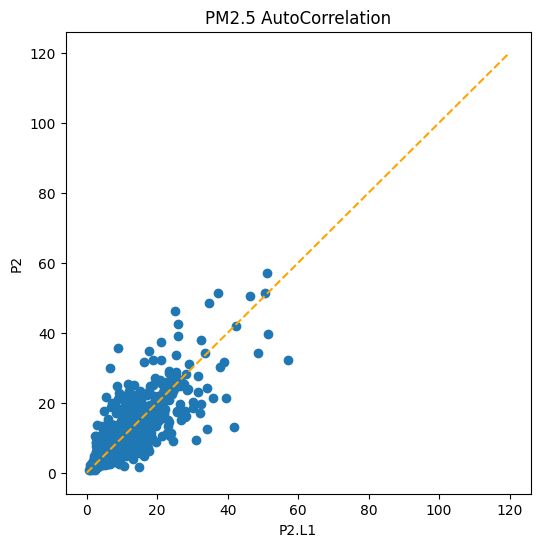

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x=df["P2.L1"], y=df["P2"])
ax.plot([0, 120], [0, 120], linestyle="--", color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 AutoCorrelation")

This code generates an Autocorrelation Function (ACF) plot for the `P2` time series. The ACF plot shows the correlation of the time series with its own past values (lags). A slow decay in the ACF suggests the presence of trends or seasonality, which is evident in the plot.

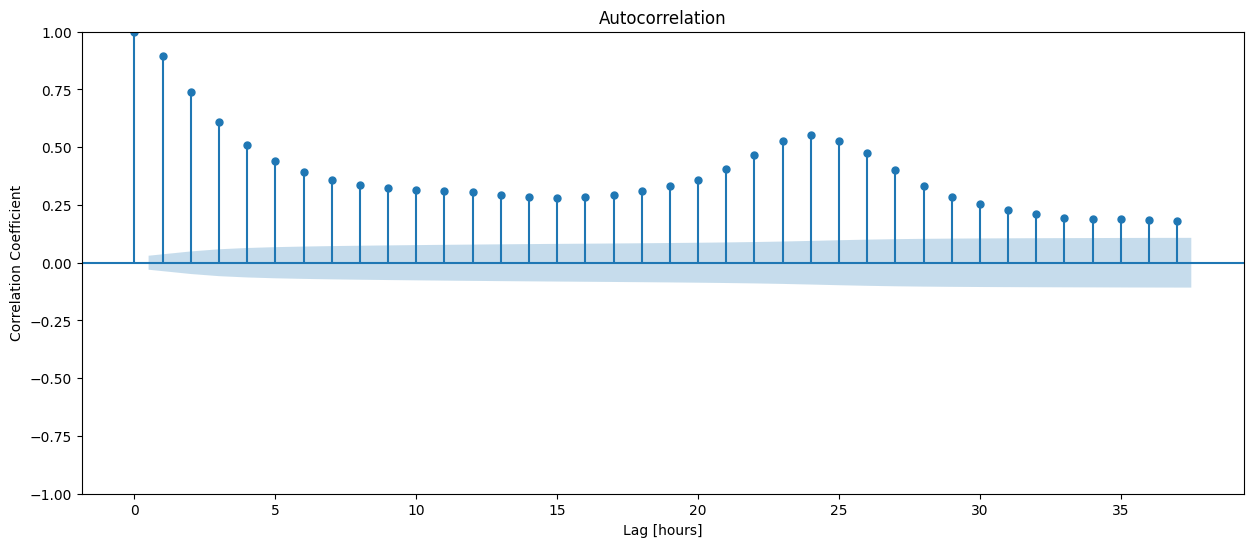

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y = df["P2"] # Define y before using it
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

This cell generates a Partial Autocorrelation Function (PACF) plot for the `P2` time series. The PACF plot shows the direct correlation between an observation and its lagged values, with the indirect correlations (due to intermediate lags) removed. This helps in identifying the order of an Autoregressive (AR) model.

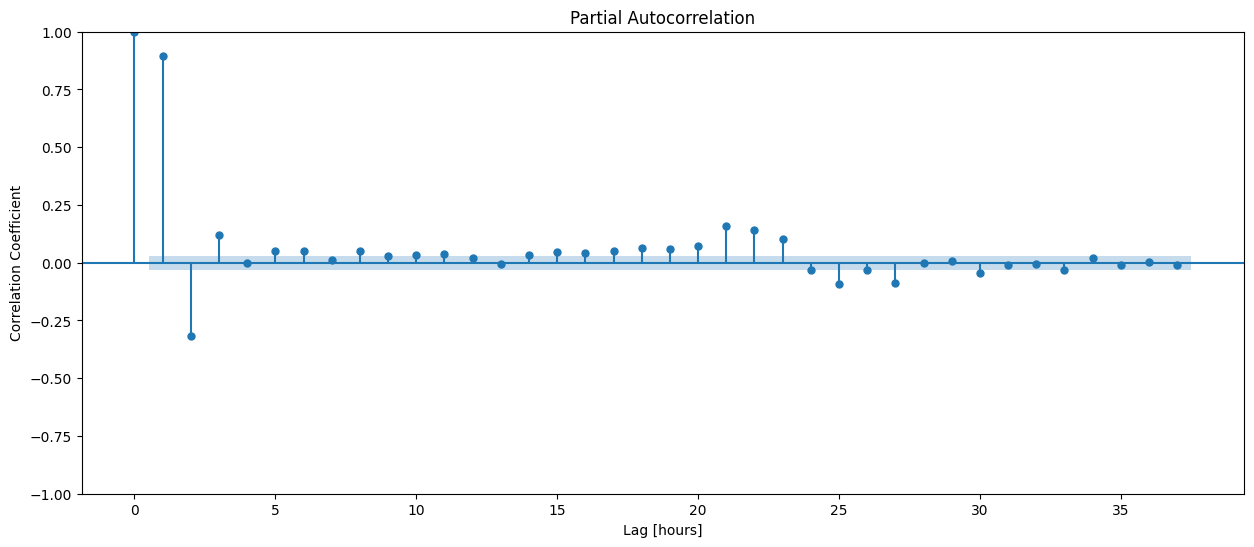

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

This code prepares the data for machine learning by defining the target variable `y` as the `P2` column and the features `X` as all other columns (in this case, only `P2.L1`). This separation is standard practice before training a predictive model.

In [ ]:
target = "P2"
y = df["P2"]
X = df.drop(columns=target)

In [ ]:
int(len(X))

4184

The dataset is split into training and testing sets. `80%` of the data is allocated for training (`X_train`, `y_train`), and the remaining `20%` for testing (`X_test`, `y_test`).

In [ ]:
cutoff = int(len(X) * 0.8)

# Training Data
X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]

# Testing Data
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (3347, 1)
X_test shape: (837, 1)


In [ ]:
len(X_train) + len(X_test) == len(X)

True

A baseline model is established by predicting the mean of the training target variable (`P2`). The Mean Absolute Error (MAE) for this baseline model is calculated. This provides a simple benchmark against which more complex models can be compared. The output shows the mean P2 reading (`8.17`) and the baseline MAE (`3.8`), indicating that a model needs to achieve an MAE lower than `3.8` to be considered better than simply predicting the average.

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 8.17
Baseline MAE: 3.8


This cell imports `PolynomialFeatures` from `sklearn.preprocessing` and initializes it with `degree=2`. It then transforms the `X_train` data into polynomial features. This allows the linear model to capture non-linear relationships between the features and the target variable by creating new features that are combinations and powers of the existing ones.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_train_trans = poly_reg.fit_transform(X_train)

A Lasso (Least Absolute Shrinkage and Selection Operator) regression model is initialized with `max_iter=10000` and `alpha=0.1`, and then fitted to the polynomial-transformed training data (`X_train_trans`, `y_train`). Lasso is a type of linear regression that includes L1 regularization, which can help in feature selection and preventing overfitting.

In [ ]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(max_iter=10000, alpha=0.1)
lasso_model.fit(X_train_trans, y_train)

Lasso(alpha=0.1, max_iter=10000)

This cell calculates and prints the R-squared score of the Lasso model on the training data. The R-squared value of `0.83` indicates that `83%` of the variance in the `y_train` can be explained by the model, suggesting a reasonably good fit on the training data.

In [ ]:
round(lasso_model.score(X_train_trans, y_train), 2)

0.83

The `X_test` data is transformed using the same `PolynomialFeatures` object (`poly_reg`) that was fitted on the training data. This ensures consistency in feature creation. Then, the R-squared score of the Lasso model on this transformed test data (`X_test_trans`, `y_test`) is calculated. An R-squared of `0.75` on the test set indicates that the model generalizes fairly well to unseen data, though there's a slight drop from the training score, suggesting minor overfitting.

In [ ]:
X_test_trans = poly_reg.transform(X_test)
round(lasso_model.score(X_test_trans, y_test), 2)

0.75

This cell calculates the Mean Absolute Error (MAE) for both the training and test sets using the Lasso model's predictions. MAE measures the average magnitude of the errors, providing a more interpretable metric than R-squared in some contexts. The training MAE is `0.98` and the test MAE is `1.76`. The increase in MAE from training to test set suggests some overfitting, but the model still performs significantly better than the baseline MAE of `3.8`.

In [ ]:

training_mae = mean_absolute_error(y_train, lasso_model.predict(X_train_trans))
test_mae = mean_absolute_error(y_test, lasso_model.predict(X_test_trans))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.98
Test MAE: 1.76


This cell uses the fitted Lasso model to predict PM2.5 values on the `X_test_trans` dataset. It then creates `df_pred_test`, a DataFrame combining the actual `y_test` values and the `y_pred_lasso` predictions, preparing the data for visualization.

In [ ]:
import plotly.express as px
y_pred_lasso = lasso_model.predict(X_test_trans)

df_pred_test = pd.DataFrame({
    "Actual PM2.5": y_test,
    "Predicted PM2.5": y_pred_lasso
})


This cell generates an interactive line plot using `plotly.express` to visualize the 'Actual PM2.5' values against the 'Predicted PM2.5' values from the Lasso model on the test dataset. The `fig.update_layout` function adds a descriptive title and appropriate axis labels, making the plot clear and interpretable. The successful execution indicates the plot was generated and displayed, allowing for a visual assessment of the model's performance.

In [ ]:
fig = px.line(df_pred_test, labels={"value": "PM2.5 Concentration"})
fig.update_layout(
    title="Actual vs. Predicted PM2.5 Concentrations (Lasso Model)",
    xaxis_title="Timestamp",
    yaxis_title="PM2.5 Concentration"
)
fig.show()